In [29]:
import yfinance as yf
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import numpy as np


In [96]:
np.random.seed(42)

In [97]:
sp500 = yf.Ticker("RELIANCE.NS")
sp500 = sp500.history(period="max")

In [98]:
sp500.index = pd.to_datetime(sp500.index)

In [99]:
sp500.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1996-01-01 00:00:00+05:30,4.618592,4.643374,4.588177,4.635489,104121369,0.0,0.0
1996-01-02 00:00:00+05:30,4.624224,4.646753,4.565646,4.599441,168743308,0.0,0.0
1996-01-03 00:00:00+05:30,4.674916,4.887822,4.624225,4.634363,209323879,0.0,0.0
1996-01-04 00:00:00+05:30,4.590430,4.605074,4.529599,4.591556,216900264,0.0,0.0
1996-01-05 00:00:00+05:30,4.573533,4.573533,4.520588,4.560015,166708467,0.0,0.0


<Axes: xlabel='Date'>

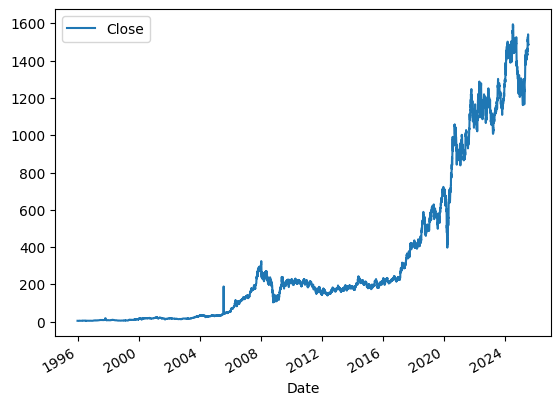

In [9]:
sp500.plot.line(y="Close", use_index=True)

In [100]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [101]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [102]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [103]:
sp500 = sp500.loc["1990-01-01":].copy()

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [ ]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    new_predictors+= [ratio_column, trend_column]

In [14]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [ ]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1999-11-01 00:00:00+05:30,12.420323,12.467871,11.445611,11.509007,114373142,12.378063,1,0.961174,0.0,0.905069,0.0,1.042669,27.0,1.380827,116.0,1.619984,458.0
1999-11-02 00:00:00+05:30,11.358444,12.430893,11.226369,12.378063,129022957,11.910517,0,1.036382,1.0,0.990782,1.0,1.115980,28.0,1.480621,116.0,1.740405,459.0
1999-11-03 00:00:00+05:30,12.700324,12.700324,11.744103,11.910517,175844467,11.944854,1,0.980750,1.0,0.974708,1.0,1.069273,28.0,1.420777,115.0,1.672955,458.0
1999-11-04 00:00:00+05:30,11.825986,12.174663,11.680704,11.944854,122838876,12.282966,1,1.001439,1.0,0.992406,2.0,1.067558,29.0,1.420869,116.0,1.676047,459.0
1999-11-05 00:00:00+05:30,11.939571,12.457306,11.939571,12.282966,131084769,12.282966,0,1.013956,2.0,1.023147,3.0,1.092182,30.0,1.456768,116.0,1.721623,460.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-07 00:00:00+05:30,1526.599976,1544.800049,1525.000000,1541.500000,7251074,1537.599976,0,1.004627,2.0,1.009654,3.0,1.091173,36.0,1.132849,128.0,1.251307,519.0
2025-07-08 00:00:00+05:30,1536.000000,1544.900024,1530.199951,1537.599976,7171261,1519.000000,0,0.998733,1.0,1.005888,2.0,1.083908,35.0,1.130135,127.0,1.247614,519.0
2025-07-09 00:00:00+05:30,1536.699951,1551.000000,1510.099976,1519.000000,8870660,1517.199951,0,0.993915,0.0,0.993694,2.0,1.067034,34.0,1.116715,126.0,1.232011,519.0


In [ ]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [ ]:
predictions = backtest(sp500, model, new_predictors)

In [ ]:
predictions["Predictions"].value_counts()

Predictions
0.0    3589
1.0     324
Name: count, dtype: int64

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5339506172839507

In [ ]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.507283
0    0.492717
Name: count, dtype: float64

In [ ]:
predictions

,Target,Predictions
Date,,
2009-09-01 00:00:00+05:30,0,0.0
2009-09-02 00:00:00+05:30,0,0.0
2009-09-03 00:00:00+05:30,1,0.0
2009-09-04 00:00:00+05:30,1,0.0
2009-09-07 00:00:00+05:30,1,0.0
...,...,...
2025-07-07 00:00:00+05:30,0,0.0
2025-07-08 00:00:00+05:30,0,0.0
2025-07-09 00:00:00+05:30,0,0.0


In [2]:
%pip install prophet


In [108]:
%pip install scikit-learn

In [111]:
from prophet import Prophet
from sklearn.model_selection import train_test_split

sp500.head()

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1996-01-01 00:00:00+05:30,4.618592,4.643374,4.588177,4.635489,104121369,4.599441,0
1996-01-02 00:00:00+05:30,4.624224,4.646753,4.565646,4.599441,168743308,4.634363,1
1996-01-03 00:00:00+05:30,4.674916,4.887822,4.624225,4.634363,209323879,4.591556,0
1996-01-04 00:00:00+05:30,4.590430,4.605074,4.529599,4.591556,216900264,4.560015,0
1996-01-05 00:00:00+05:30,4.573533,4.573533,4.520588,4.560015,166708467,4.377523,0


In [112]:
sp500.reset_index(inplace=True)

In [113]:
sp500.head()

,Date,Open,High,Low,Close,Volume,Tomorrow,Target
0,1996-01-01 00:00:00+05:30,4.618592,4.643374,4.588177,4.635489,104121369,4.599441,0
1,1996-01-02 00:00:00+05:30,4.624224,4.646753,4.565646,4.599441,168743308,4.634363,1
2,1996-01-03 00:00:00+05:30,4.674916,4.887822,4.624225,4.634363,209323879,4.591556,0
3,1996-01-04 00:00:00+05:30,4.590430,4.605074,4.529599,4.591556,216900264,4.560015,0
4,1996-01-05 00:00:00+05:30,4.573533,4.573533,4.520588,4.560015,166708467,4.377523,0


In [136]:
df = sp500[['Date','Tomorrow']]
df.head()

,Date,Tomorrow
0,1996-01-01 00:00:00+05:30,4.599441
1,1996-01-02 00:00:00+05:30,4.634363
2,1996-01-03 00:00:00+05:30,4.591556
3,1996-01-04 00:00:00+05:30,4.560015
4,1996-01-05 00:00:00+05:30,4.377523


In [137]:
df = df.rename(columns={'Date': 'ds','Tomorrow':'y'})
df[['y']] = (df[['y']]-df[['y']].mean())/df[['y']].std()
df.head()

,ds,y
0,1996-01-01 00:00:00+05:30,-0.778419
1,1996-01-02 00:00:00+05:30,-0.778335
2,1996-01-03 00:00:00+05:30,-0.778437
3,1996-01-04 00:00:00+05:30,-0.778513
4,1996-01-05 00:00:00+05:30,-0.778952


In [138]:
df['y'] = df['y'].fillna(df['y'].mean())
df['ds'] = df['ds'].dt.tz_localize(None)

In [139]:
split_date = '2023-01-01'

train_df = df[df['ds'] < split_date]
test_df = df[df['ds'] >= split_date]


In [140]:
model = Prophet()

#Fitting the model
model.fit(train_df)



INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx8q715ro/ipvi3bay.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx8q715ro/pejaurbx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57307', 'data', 'file=/tmp/tmpx8q715ro/ipvi3bay.json', 'init=/tmp/tmpx8q715ro/pejaurbx.json', 'output', 'file=/tmp/tmpx8q715ro/prophet_modelbj7valev/prophet_model-20250715124604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:46:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:46:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [141]:
# dataframe for predcition

future = pd.concat([
    train_df[['ds']],
    test_df[['ds']]
]).drop_duplicates().sort_values('ds').reset_index(drop=True)
future.dropna(inplace = True)
future.head()

,ds
0,1996-01-01
1,1996-01-02
2,1996-01-03
3,1996-01-04
4,1996-01-05


In [142]:
prediction = model.predict(future)
prediction = prediction[['ds', 'yhat']]
prediction.head()

,ds,yhat
0,1996-01-01,-0.783634
1,1996-01-02,-0.781425
2,1996-01-03,-0.781077
3,1996-01-04,-0.779671
4,1996-01-05,-0.781787


In [143]:
#Model Accuracy

mae = (df['y'] - prediction['yhat']).abs().mean()
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 0.07966599482107191


In [144]:
print(df['y'].isna().sum(), "NaNs in test values")
print(prediction['yhat'].isna().sum(), "NaNs in predicted values")

0 NaNs in test values
0 NaNs in predicted values


In [145]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(df['y'].values, prediction['yhat'].values)
print("MAE:", mae)

MAE: 0.07966599482107191
